# Image Segmentation Playground

## MIT Driving Scene Segmentation

This tutorial demostrates the steps to run DeepLab semantic scene segmentation model on a sample video from MIT Driving Scene Segmentation Dataset.

### Step 1: Installation

In [ ]:
# Tensorflow
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

TensorFlow 1.x selected.
1.15.2


### Step 2: Build the model


**[DeepLab](https://github.com/tensorflow/models/tree/master/research/deeplab)** is a state-of-art deep learning model for semantic image segmentation, where the goal is to assign semantic labels (e.g., person, dog, cat and so on) to every pixel in the input image. Some segmentation results on Flickr images:

![](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/vis1.png?raw=true)

![](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/vis2.png?raw=true)

In the driving context, we aim to obtain a semantic understanding of the front driving scene throught the camera input. This is important for driving safety and an essential requirement for all levels of autonomous driving. The first step is to build the model and load the pre-trained weights. In this demo, we use the model checkpoint trained on [Cityscapes](https://www.cityscapes-dataset.com/) dataset.

![](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png)

    ![](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/zuerich00.png)

In [ ]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

### Step 3: Creating helper functions

In [ ]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Step 4: Load the model from a frozen graph
There are two model checkpoints pre-trained on Cityscapes with different network backbones: MobileNetV2 and Xception65. We default to use MobileNetV2 for faster inference.

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


### Step 5: Run the model

downloading the sample image...
running deeplab on the sample image...


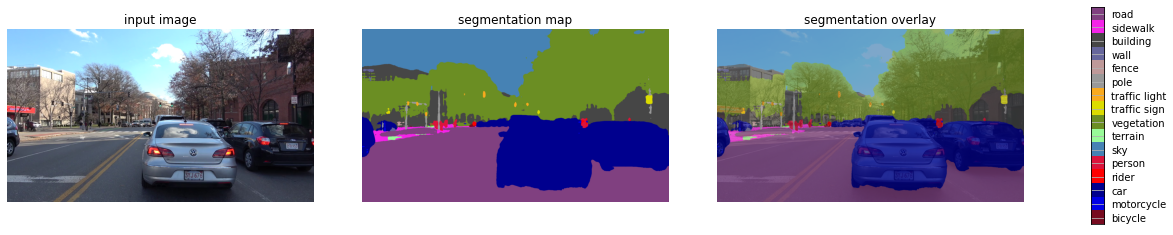

In [ ]:
# run on sample image
# The sample image is frame #0 in the MIT Driving Scene Segmentation (DriveSeg) Dataset
SAMPLE_IMAGE = 'mit_driveseg_sample.png'
if not os.path.isfile(SAMPLE_IMAGE):
    print('downloading the sample image...')
    SAMPLE_IMAGE = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.png?raw=true')[0]
print('running deeplab on the sample image...')

def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)

run_visualization(SAMPLE_IMAGE)

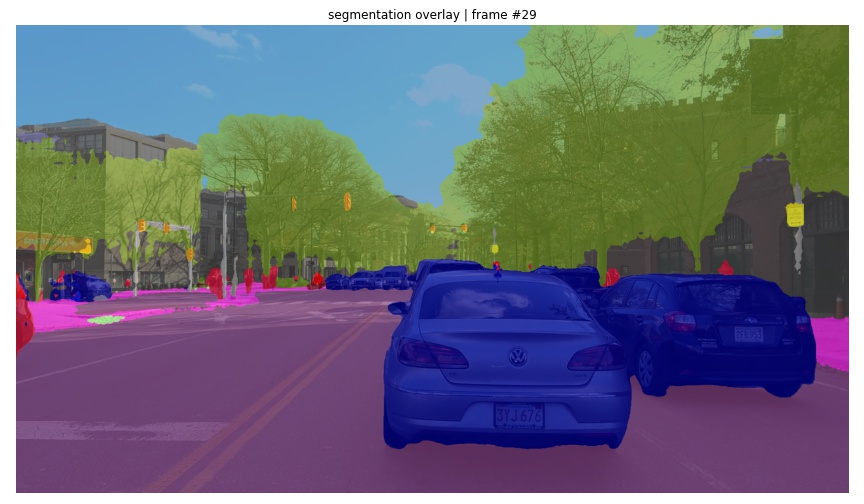

In [ ]:
# Run on the sample video
# The sample video is frame #0 to #597 in the MIT DriveSeg Dataset
def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)


SAMPLE_VIDEO = 'mit_driveseg_sample.mp4'
if not os.path.isfile(SAMPLE_VIDEO): 
    print('downloading the sample video...')
    SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

### Step 6: Evaluate

downloading the sample ground truth...
visualizing ground truth annotation on the sample image...


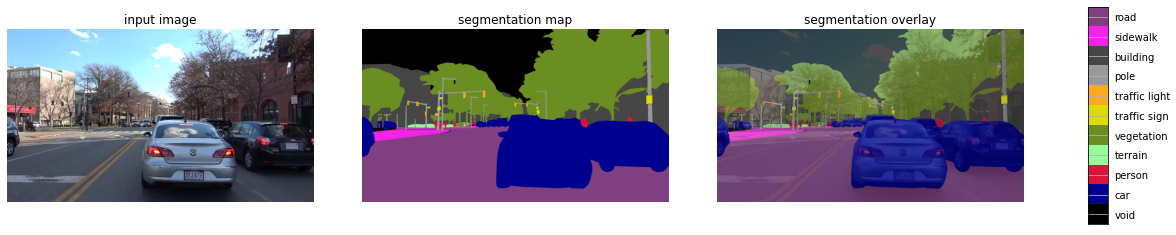

In [ ]:
# read annotation tar file
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()
    
    def fetch(self, index):
        """Get ground truth by index.

        Args:
            index: The frame number.

        Returns:
            gt: Ground truth segmentation map.
        """
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt


SAMPLE_GT = 'mit_driveseg_sample_gt.tar.gz'
if not os.path.isfile(SAMPLE_GT): 
    print('downloading the sample ground truth...')
    SAMPLE_GT = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample_gt.tar.gz')[0]

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
vis_segmentation(original_im, gt)

#### Evaluate on the sample image
- There are many ways to measure the performance of a segmentation model. The most straight forward one is pixel accuracy, which calculates how many pixels are correctly predicted. 
- Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [ ]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample image...
pixel accuracy: 0.90720
mean class IoU: 0.5383739999999999
class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person     car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  ------
0.96126     0.34571     0.52489  0.16418          0.49512         0.52207       0.82085    0.05721   0.52215  0.9703


#### Evaluate on the sample video

In [ ]:
print('evaluating on the sample video...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video...


100%|██████████| 30/30 [00:46<00:00,  1.54s/it]

pixel accuracy: 0.8995
mean class IoU: 0.5276
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4104      0.5283  0.1594           0.4487          0.5508        0.8295     0.0474    0.3879  0.9582


### Optional: leverage temporal information
One thing makes video scene segmentation different from image segmentation is the availability of previous frames, which contains valuable temporal information that may help with perception. The open question is how can we use such temporal information. Let's try conbine the prediction of two frames instead of only one frame, making smoother predictions over time.

In [ ]:
print('evaluating on the sample video with temporal smoothing...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []
prev_seg_map_logits = 0

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])
    
    # Get the logits instead of label prediction
    seg_map_logits = MODEL.run(original_im, OUTPUT_TENSOR_NAME='ResizeBilinear_3:0')
    
    # Add previous frame's logits and get the results
    seg_map = np.argmax(seg_map_logits + prev_seg_map_logits, -1)
    prev_seg_map_logits = seg_map_logits
    
    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)
    
class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video with temporal smoothing...


100%|██████████| 30/30 [00:47<00:00,  1.59s/it]

pixel accuracy: 0.8998
mean class IoU: 0.5284
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4064      0.5285   0.158           0.4504           0.551        0.8297     0.0453    0.4008  0.9586


## Torchvision DeepLabV3



This is a [DeepLabV3](https://arxiv.org/abs/1706.05587) colab notebook using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html).

### Step 1: Initialize DeepLabV3 and download pretrained weights


In [ ]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)
  
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.eval().cuda()

### Step 2: Segment objects on a test image

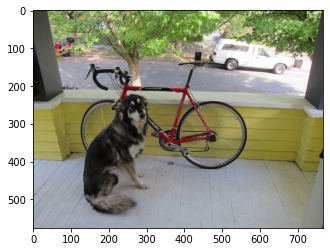

In [ ]:
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/dog.jpg'


image_file = basename(IMAGE_URL)
!wget -q -O {image_file} {IMAGE_URL}
plt.imshow(matplotlib.image.imread(image_file))

In [ ]:
# Execute Mask R-CNN model on that image and show the result
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cuda()
output = model(image_tensor.unsqueeze(0))
print('executed in %.3fs' % (time.time() - t))

In [ ]:
# visualize
#
# visualization code copied from: https://github.com/fregu856/deeplabv3/blob/master/visualization/run_on_seq.py
#
outputs = output['out'].cpu().numpy() # (shape: (batch_size, num_classes, img_h, img_w))
pred_label_imgs = np.argmax(outputs, axis=1) # (shape: (batch_size, img_h, img_w))
pred_label_imgs = pred_label_imgs.astype(np.uint8)

label_names = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'] 
def label_img_to_color(img):
    label_to_color = {
        0: [128, 64,128], 1: [244, 35,232], 2: [ 70, 70, 70], 3: [102,102,156],
        4: [190,153,153], 5: [153,153,153], 6: [250,170, 30], 7: [220,220,  0],
        8: [107,142, 35], 9: [152,251,152], 10: [ 70,130,180], 11: [220, 20, 60],
        12: [255,  0,  0], 13: [  0,  0,142], 14: [  0,  0, 70], 15: [  0, 60,100],
        16: [  0, 80,100], 17: [  0,  0,230], 18: [119, 11, 32], 19: [81,  0, 81]
        }

    img_height, img_width = img.shape
    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col]
            img_color[row, col] = np.array(label_to_color[label])

    return img_color


i = 0
pred_label_img = pred_label_imgs[i] # (shape: (img_h, img_w))
img = image_tensor #imgs[i] # (shape: (3, img_h, img_w))

img = img.data.cpu().numpy()
img = np.transpose(img, (1, 2, 0)) # (shape: (img_h, img_w, 3))
img = img*np.array([0.229, 0.224, 0.225])
img = img + np.array([0.485, 0.456, 0.406])
img = img*255.0
img = img.astype(np.uint8)

pred_label_img_color = label_img_to_color(pred_label_img)
overlayed_img = 0.35*img + 0.65*pred_label_img_color
overlayed_img = overlayed_img.astype(np.uint8)

plt.figure(figsize=(20, 15))
plt.imshow(overlayed_img)

## DeepLab TPU

### Step 1: Installation

In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


### Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [ ]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


### Step 4: Run on sample images
Select one of sample images (leave IMAGE_URL empty) or feed any internet image url for inference.

Note that this colab uses single scale inference for fast computation, so the results may slightly differ from the visualizations in the README file, which uses multi-scale and left-right flipped inputs.

running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image2.jpg?raw=true...


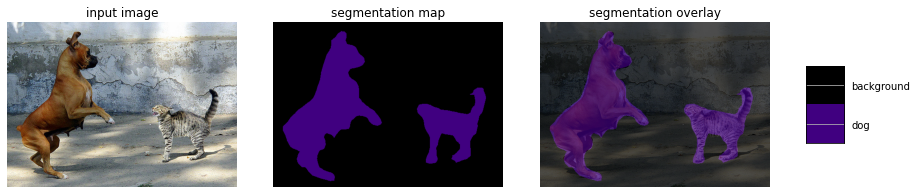

In [ ]:

SAMPLE_IMAGE = 'image2'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

## CSAILVision semantic segmention models



This is a semantic segmentation notebook using an [ADE20K](http://groups.csail.mit.edu/vision/datasets/ADE20K/) pretrained model from the open source project [CSAILVision/semantic-segmentation-pytorch](https://github.com/CSAILVision/semantic-segmentation-pytorch).

### Step 1: Installation

In [ ]:
## Clone repo and install dependencies
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CSAILVision/semantic-segmentation-pytorch.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  ## clone and install dependencies
  !git clone -q $git_repo_url
  #!cd $project_name && pip install -q -r requirement.txt
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

### Step 2: Download a pretrained model

According to [https://github.com/CSAILVision/semantic-segmentation-pytorch#performance](https://github.com/CSAILVision/semantic-segmentation-pytorch#performance),  **UperNet101** was the best performing model. We will use it as the pretrained model:

In [ ]:
ENCODER_NAME = 'resnet101'
DECODER_NAME = 'upernet'
PRETRAINED_ENCODER_MODEL_URL = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-%s-%s/encoder_epoch_50.pth' % (ENCODER_NAME, DECODER_NAME)
PRETRAINED_DECODER_MODEL_URL = 'http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-%s-%s/decoder_epoch_50.pth' % (ENCODER_NAME, DECODER_NAME)

pretrained_encoder_file = basename(PRETRAINED_ENCODER_MODEL_URL)
if not exists(pretrained_encoder_file):
  !wget -q $PRETRAINED_ENCODER_MODEL_URL
pretrained_decoder_file = basename(PRETRAINED_DECODER_MODEL_URL)
if not exists(pretrained_decoder_file):
  !wget -q $PRETRAINED_DECODER_MODEL_URL

### Step 3: Initialize the model

In [ ]:
from types import SimpleNamespace
import torch
from models import ModelBuilder, SegmentationModule
from dataset import TestDataset
from utils import colorEncode
from scipy.io import loadmat

## options
options = SimpleNamespace(fc_dim=2048,
                          num_class=150,
                          imgSizes = [300, 400, 500, 600],
                          imgMaxSize=1000,
                          padding_constant=8,
                          segm_downsampling_rate=8)

## create model
builder = ModelBuilder()
net_encoder = builder.build_encoder(arch=ENCODER_NAME, weights=pretrained_encoder_file,
                                    fc_dim=options.fc_dim)
net_decoder = builder.build_decoder(arch=DECODER_NAME, weights=pretrained_decoder_file,
                                    fc_dim=options.fc_dim, num_class=options.num_class, use_softmax=True)
segmentation_module = SegmentationModule(net_encoder, net_decoder, torch.nn.NLLLoss(ignore_index=-1))
segmentation_module = segmentation_module.eval()
torch.set_grad_enabled(False)

if torch.cuda.is_available():
  segmentation_module = segmentation_module.cuda()

## test on a given image
def test(test_image_name):
  dataset_test = TestDataset([{'fpath_img': test_image_name}], options, max_sample=-1)
  
  batch_data = dataset_test[0]
  segSize = (batch_data['img_ori'].shape[0], batch_data['img_ori'].shape[1])
  img_resized_list = batch_data['img_data']
  
  scores = torch.zeros(1, options.num_class, segSize[0], segSize[1])
  if torch.cuda.is_available():
    scores = scores.cuda()

  for img in img_resized_list:
    feed_dict = batch_data.copy()
    feed_dict['img_data'] = img
    del feed_dict['img_ori']
    del feed_dict['info']
    if torch.cuda.is_available():
      feed_dict = {k: o.cuda() for k, o in feed_dict.items()}

    ## forward pass
    pred_tmp = segmentation_module(feed_dict, segSize=segSize)
    scores = scores + pred_tmp / len(options.imgSizes)

    _, pred = torch.max(scores, dim=1)
    return pred.squeeze(0).cpu().numpy()

Loading weights for net_encoder
Loading weights for net_decoder


### Step 4: Evaluate on a test image

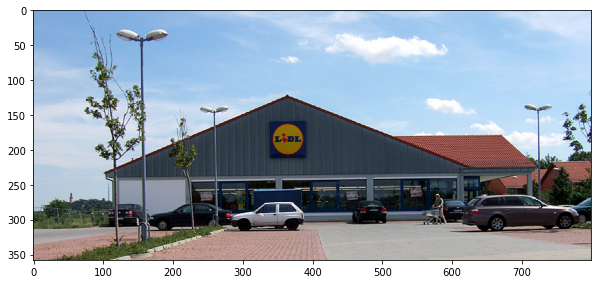

In [ ]:
## First, download a test image from the internet
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/lidl.jpg'

image_file = basename(IMAGE_URL)
!wget -q -O $image_file $IMAGE_URL

plt.figure(figsize=(10, 5))
plt.imshow(matplotlib.image.imread(image_file))

# samples: 1
executed in 8.972s


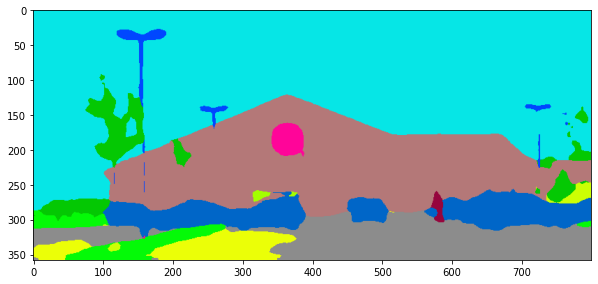

In [ ]:
## Now, test on the downloaded image
t = time.time()
pred = test(image_file)
print("executed in %.3fs" % (time.time()-t))

pred_color = colorEncode(pred, loadmat(os.path.join(project_name, 'data/color150.mat'))['colors'])
plt.figure(figsize=(10, 5))
plt.imshow(pred_color)

## Instance Segmentation with CenterMask

This uses an open source project [youngwanLEE/CenterMask](https://github.com/youngwanLEE/CenterMask) to make instance segmentation

### Step 1: Installation

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/youngwanLEE/CenterMask.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  !pip install -q ninja yacs cython tqdm
  !cd {project_name} && python setup.py build develop
  
import sys
sys.path.append(project_name)
import time
import glob
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

### Step 2: Download pretrained models

In [ ]:
pretrained_model_path = join(project_name, 'centermask-V2-99-FPN-ms-3x.pth')
pretrained_model_cfg_path = join(project_name, 'configs/centermask/centermask_V_99_eSE_FPN_ms_2x.yaml')
if not exists(pretrained_model_path):
  # download a pretrained V2-99-FPN model Mask AP 40.2, Box AP 45.6
  !wget -O {pretrained_model_path} https://www.dropbox.com/s/99i7ydsz2ngrvu1/centermask-V2-99-FPN-ms-3x.pth?dl=1

--2020-04-09 08:32:58--  https://www.dropbox.com/s/99i7ydsz2ngrvu1/centermask-V2-99-FPN-ms-3x.pth?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99i7ydsz2ngrvu1/centermask-V2-99-FPN-ms-3x.pth [following]
--2020-04-09 08:32:58--  https://www.dropbox.com/s/dl/99i7ydsz2ngrvu1/centermask-V2-99-FPN-ms-3x.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2bd26b27233582afcf13ee898.dl.dropboxusercontent.com/cd/0/get/A1hxSETg62o-5dnqAkqFdnMcnQy02-oYKkazFpuJpjF5JRTPksxEVZEO3iNEJnTz3bWe9B-DnFOGMv2eQJ3X4FndmtjIVWPtszAEwfdW4Q94aZmaVL0YPVW86npIqTeJSLs/file?dl=1# [following]
--2020-04-09 08:32:58--  https://ucf2bd26b27233582afcf13ee898.dl.dropboxusercontent.com/cd/0/get/A1hxSETg62o-5dnqAkqFdnMcnQy02-oYKkazFpuJpjF5JRTPksxEVZEO3i

### Step 3: Evaluate on a test image

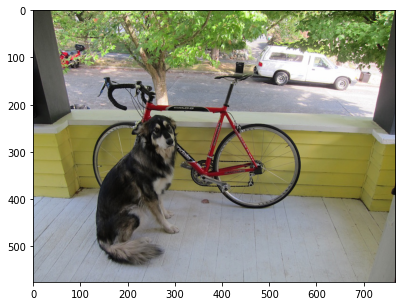

In [ ]:
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/dog.jpg'

image_file = basename(IMAGE_URL)
image_file_ext = splitext(image_file)[1][1:]
images_dir = 'images'
!mkdir -p {images_dir} && rm -rf {images_dir}/*
!wget -q -O {images_dir}/{image_file} {IMAGE_URL}

plt.figure(figsize=(10, 5))
plt.imshow(matplotlib.image.imread(join(images_dir, image_file)))

In [ ]:
!mkdir -p output && rm -rf output/*
!python CenterMask/demo/centermask_demo.py --weights {pretrained_model_path} --config-file {pretrained_model_cfg_path} --conf_th 0.3 --input {images_dir} --output_dir output --display_text 1 --display_scores 1

file 0
dog processing...
dog	inference time: 0.55s


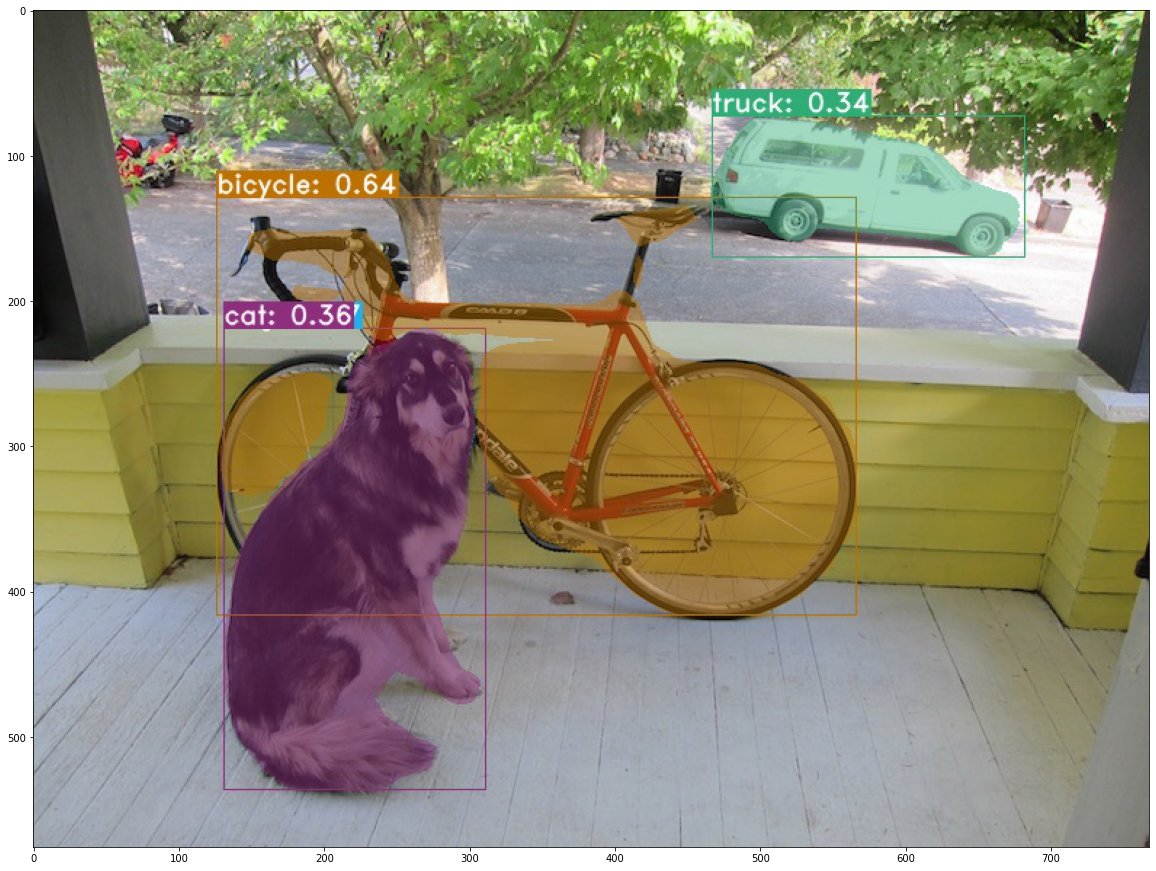

In [ ]:
# Visualize the results
plt.figure(figsize=(20, 20))
plt.imshow(matplotlib.image.imread(glob.glob('output/*')[0]))

## Real Time Semantic Segmentation with LightNet++

This notebook uses an open source project [LightNet++](https://github.com/ansleliu/LightNetPlusPlus) to segment cars, streets etc. in YouTube videos.

### Step 1: Installation

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/ansleliu/LightNetPlusPlus.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !pip install -q youtube-dl ninja
  
  # install NVidia/apex
  !git clone -q --depth 1 https://github.acom/NVIDIA/apex.git
  !cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)


import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn as nn

from modules.inplace_abn.iabn import InPlaceABNSync
from functools import partial

from apex.fp16_utils import *
from apex import amp
import apex

cudnn.benchmark = True
assert torch.backends.cudnn.enabled, "fp16 mode requires cudnn backend to be enabled."
amp_handle = amp.init(enabled=True)

from models.shufflenetv2plus import ShuffleNetV2Plus

### Step 2: Initialize LightNet++ (ShuffleNet based)

In [ ]:
# initialize model
model = ShuffleNetV2Plus(num_classes=19, fuse_chns=512, aspp_chns=256, aspp_dilate=(12, 24, 36), width_multi=1.0,
                             norm_act=partial(InPlaceABNSync, activation="leaky_relu", slope=0.01))
model = apex.parallel.convert_syncbn_model(model)
model = nn.DataParallel(model, device_ids=[0]).cuda()
pre_weight = torch.load(join(project_name, 'checkpoint/deepdrive_shufflenetv2plus_x1.0.pkl'))
pre_weight = pre_weight['model_state']
model.load_state_dict(pre_weight)
del pre_weight
model = model.eval()


# utils copied from https://github.com/ansleliu/LightNetPlusPlus/blob/master/deploy/cityscapes/video_demo/video_demo.py
def decode_segmap(pred, label_colours, num_classes):
    r = pred.copy()
    g = pred.copy()
    b = pred.copy()
    for l in range(0, num_classes):
        r[pred == l] = label_colours[l][0]
        g[pred == l] = label_colours[l][1]
        b[pred == l] = label_colours[l][2]

    rgb = np.zeros((pred.shape[0], pred.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb
  
colors = [  # [  0,   0,   0],
          [128, 64, 128],
          [244, 35, 232],
          [70, 70, 70],
          [102, 102, 156],
          [190, 153, 153],
          [153, 153, 153],
          [250, 170, 30],
          [220, 220, 0],
          [107, 142, 35],
          [152, 251, 152],
          [0, 130, 180],
          [220, 20, 60],
          [255, 0, 0],
          [0, 0, 142],
          [0, 0, 70],
          [0, 60, 100],
          [0, 80, 100],
          [0, 0, 230],
          [119, 11, 32]]

label_colours = dict(zip(range(19), colors))
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence',
               'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain',
               'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
               'motorcycle', 'bicycle']

net_h, net_w, color_bar_w = 720, 1280, 120
frame_size = (net_w + color_bar_w, net_h)

color_map = label_colours
num_classes = 19

grid_height = int(net_h // num_classes)
start_pixel = int((net_h % num_classes) / 2)

color_bar = np.ones((net_h, color_bar_w, 3), dtype=np.uint8) * 128
for train_id in np.arange(num_classes):
    end_pixel = start_pixel + grid_height
    color_bar[start_pixel:end_pixel, :, :] = color_map[train_id]

    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(color_bar, class_names[train_id + 1],
                (2, start_pixel + 5 + int(grid_height // 2)),
                font, 0.55, (255, 255, 255), 1, cv2.LINE_AA)

    start_pixel = end_pixel
color_bar = color_bar[:, :, ::-1]

mean = [0.2997, 0.3402, 0.3072]
std = [0.1549, 0.1579, 0.1552]
trans_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

### Step 3: Segment an YouTube video with LightNet++

In [ ]:
YOUTUBE_ID = 't4cN3JKf0hE'


YouTubeVideo(YOUTUBE_ID)

In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v={YOUTUBE_ID}

In [ ]:
f = 0
video_capture = cv2.VideoCapture()
if video_capture.open('youtube.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, frame_size)
  
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break
    frame = cv2.resize(frame, (net_w, net_h))
      
    image = trans_norm(frame)
    image = torch.unsqueeze(image, dim=0).cuda()  # [N, C, H, W]
    start_time = time.time()
    prediction = F.softmax(model(image), dim=1).argmax(dim=1)
    print("> Inference Time: {}s".format(time.time() - start_time))
    
    prediction = np.squeeze(prediction.cpu().numpy())
    prediction = decode_segmap(prediction, label_colours, num_classes)
    prediction = prediction.astype(np.uint8)
    
    img_msk = cv2.addWeighted(frame[:, :, ::-1], 0.55, prediction, 0.45, 0)
    img_msk = img_msk[:, :, ::-1]
    img_msk_color = np.concatenate((img_msk, color_bar), axis=1)
    video_writer.write(img_msk_color)
  
    f += 1
    # only on first 300 frames
    if f > 300:
      break
      
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

In [ ]:
# Visualize the result
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

## Track/Segment Person with SiamMask

This notebook uses an open source project [SiamMask](https://github.com/foolwood/SiamMask) to track and to segment a single person on a given youtube video.

### Step 1: Installation

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/foolwood/SiamMask.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !sed -i "/torch/d" {project_name}/requirements.txt
  !cd {project_name} && pip install -q -r requirements.txt
  !cd {project_name} && bash make.sh
  !pip install -q youtube-dl
  
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'experiments', 'siammask_sharp'))
import time
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

import cv2
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

from types import SimpleNamespace
from custom import Custom
from tools.test import *

### Step 2: Download pretrained weights and initialize SiamMask

In [ ]:
exp_path = join(project_name, 'experiments/siammask_sharp')
pretrained_path1 = join(exp_path, 'SiamMask_DAVIS.pth')
pretrained_path2 = join(exp_path, 'SiamMask_VOT.pth')

# download pretrained weights
if not exists(pretrained_path1):
  !cd {exp_path} && wget http://www.robots.ox.ac.uk/~qwang/SiamMask_DAVIS.pth
if not exists(pretrained_path2):
  !cd {exp_path} && wget http://www.robots.ox.ac.uk/~qwang/SiamMask_VOT.pth
    
# init SiamMask
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg = load_config(SimpleNamespace(config=join(exp_path, 'config_davis.json')))
siammask = Custom(anchors=cfg['anchors'])
siammask = load_pretrain(siammask, pretrained_path1)
siammask = siammask.eval().to(device)

--2020-04-09 08:16:18--  http://www.robots.ox.ac.uk/~qwang/SiamMask_DAVIS.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105878246 (101M)
Saving to: ‘SiamMask_DAVIS.pth’

SiamMask_DAVIS.pth  100%[===================>] 100.97M  19.6MB/s    in 5.9s    

2020-04-09 08:16:24 (17.0 MB/s) - ‘SiamMask_DAVIS.pth’ saved [105878246/105878246]

--2020-04-09 08:16:26--  http://www.robots.ox.ac.uk/~qwang/SiamMask_VOT.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101533952 (97M)
Saving to: ‘SiamMask_VOT.pth’

SiamMask_VOT.pth    100%[===================>]  96.83M  20.2MB/s    in 5.7s    

2020-04-09 08:16:32 (17.1 MB/s) - ‘SiamMask_VOT.pth’ saved [101533952/101533952]



[2020-04-09 08:16:35,391-rk0-features.py# 66] Current training 0 layers:
	
[2020-04-09 08:16:35,394-rk0-features.py# 66] Current training 1 layers:
	
[2020-04-09 08:16:35,464-rk0-load_helper.py# 31] load pretrained model from SiamMask/experiments/siammask_sharp/SiamMask_DAVIS.pth
[2020-04-09 08:16:44,653-rk0-load_helper.py# 25] remove prefix 'module.'
[2020-04-09 08:16:44,655-rk0-load_helper.py# 18] used keys:356


### Step 3: Track a person on a test video with SiamMask
We are going to detect and track/segment a person on the following youtube video

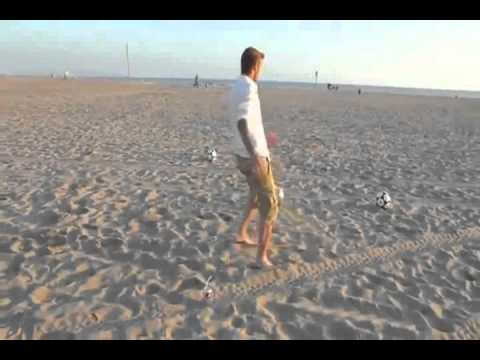

In [ ]:
YOUTUBE_ID = 'c_6-8kvLFCs'


YouTubeVideo(YOUTUBE_ID)

In [ ]:
# Download the above youtube video and detect/track/segment a single person on the first 100 frames
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v={YOUTUBE_ID}

f = 0
video_capture = cv2.VideoCapture()
if video_capture.open('youtube.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break

    if f == 0:
      # detect a person on the first frame with Mask R-CNN
      maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
      maskrcnn = maskrcnn.eval()
      output = maskrcnn([torchvision.transforms.functional.to_tensor((frame[...,::-1] / 255).astype(np.float32))])[0]

      target_pos, target_sz = None, None
      for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        # search for a person with atleast 70% probability
        if score > 0.7 and label == 1:
          box = box.numpy()
          x, y = int(box[0]), int(box[1])
          w, h = int(box[2]) - x, int(box[3]) - y
          target_pos = np.array([x + w / 2, y + h / 2])
          target_sz = np.array([w, h])
          break
      assert target_pos is not None, "no person found on the first frame!"
      print("person found:", target_pos, target_sz)
      
      # init tracker
      state = siamese_init(frame, target_pos, target_sz, siammask, cfg['hp'], device=device)
    else:
      # track
      state = siamese_track(state, frame, mask_enable=True, refine_enable=True, device=device)
      location = state['ploygon'].flatten()
      mask = state['mask'] > state['p'].seg_thr
      
      frame[:, :, 2] = (mask > 0) * 255 + (mask == 0) * frame[:, :, 2]
      cv2.polylines(frame, [np.int0(location).reshape((-1, 1, 2))], True, (0, 255, 0), 3)
      
      video_writer.write(frame)
  
    f += 1
    # only on first 100 frames
    if f > 100:
      break
      
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

[youtube] c_6-8kvLFCs: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 4.36MiB in 00:00


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



person found: [289.5 256.5] [ 77 287]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
# Finally, visualize the result
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

## Real-Time Segmentation with YOLACT



This notebook uses an open source project [YOLACT](https://github.com/dbolya/yolact) to segment objects in real-time on a given youtube video.

### Step 1: Installation

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/dbolya/yolact.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !pip install -q youtube-dl
  
import sys
sys.path.append(project_name)

from IPython.display import YouTubeVideo

     |████████████████████████████████| 1.8MB 103kB/s 


### Step 2: Download pretrained weights for YOLACT (ResNet50 based)

In [ ]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=$file_id" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$confirm_text&id=$file_id" -o $file_name
  
pretrained_model = 'yolact_resnet50_54_800000.pth'
if not exists(pretrained_model):
  download_from_google_drive('1yp7ZbbDwvMiFJEq4ptVKTYTI2VeRDXl0', pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1217      0 --:--:-- --:--:-- --:--:--  1217
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  121M    0  121M    0     0  58.7M      0 --:--:--  0:00:02 --:--:--  197M


### Step 3: Segment objects on a test video with YOLACT

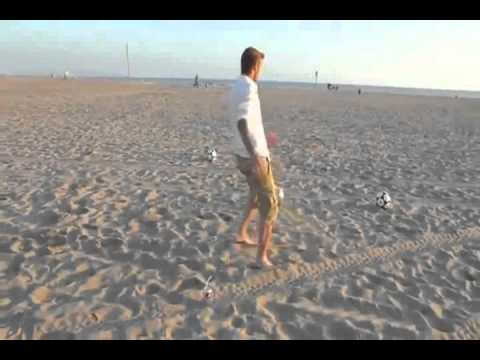

In [ ]:
YOUTUBE_ID = 'c_6-8kvLFCs'


YouTubeVideo(YOUTUBE_ID)

In [ ]:
!rm -rf youtube.mp4 input.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v={YOUTUBE_ID}
!ffmpeg -y -loglevel panic -i youtube.mp4 -t 20 input.mp4

!cd {project_name} && python eval.py --trained_model=../{pretrained_model} --score_threshold=0.3 --top_k=100 --video=../input.mp4:../pre_output.mp4
# encode with FFMPEG otherwise can't embedd in colab!
!ffmpeg -y -loglevel panic -i pre_output.mp4 output.mp4

[youtube] c_6-8kvLFCs: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 4.36MiB in 00:00
Config not specified. Parsed yolact_resnet50_config from the file name.

Loading model... Done.
Initializing model... Done.

Processing FPS: 0.00 | Video Playback FPS: 19.59 | Frames in Buffer: 0    


In [ ]:
# Visualize the results
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4')

## Pedestrian Tracking with YOLOv3 and DeepSORT



This is a pedestrian tracking demo using the open source project [ZQPei/deep_sort_pytorch](https://github.com/ZQPei/deep_sort_pytorch) which combines [DeepSORT](https://github.com/nwojke/deep_sort) with [YOLOv3](https://pjreddie.com/darknet/yolo/).

### Step 1: Install ZQPei/deep_sort_pytorch

In [ ]:
import os
from os.path import exists, join, basename

project_name = "deep_sort_pytorch"
if not exists(project_name):
  # clone and install
  !git clone -q --recursive https://github.com/ZQPei/deep_sort_pytorch.git
  
import sys
sys.path.append(project_name)

import IPython
from IPython.display import clear_output

### Step 2: Download pretrained weights

In [ ]:
yolo_pretrained_weight_dir = join(project_name, 'detector/YOLOv3/weight/')
if not exists(join(yolo_pretrained_weight_dir, 'yolov3.weights')):
  !cd {yolo_pretrained_weight_dir} && wget -q https://pjreddie.com/media/files/yolov3.weights
    
deepsort_pretrained_weight_dir = join(project_name, 'deep_sort/deep/checkpoint')
if not exists(join(deepsort_pretrained_weight_dir, 'ckpt.t7')):
  file_id = '1_qwTWdzT9dWNudpusgKavj_4elGgbkUN'
  !cd {deepsort_pretrained_weight_dir} && curl -Lb ./cookie "https://drive.google.com/uc?export=download&id={file_id}" -o ckpt.t7

### Step 3: Track pedestrians

In [ ]:
VIDEO_URL = 'http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi'
DURATION_S = 20  # process only the first 20 seconds



video_file_name = 'video.mp4'
if not exists(video_file_name):
  !wget -q $VIDEO_URL
  dowloaded_file_name = basename(VIDEO_URL)
  # convert to MP4, because we can show only MP4 videos in the colab noteook
  !ffmpeg -y -loglevel info -t $DURATION_S -i $dowloaded_file_name $video_file_name
  

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))
 
clear_output()
show_local_mp4_video('video.mp4')

In [ ]:
!cd {project_name} && python yolov3_deepsort.py --ignore_display ../video.mp4 --save_path ../output.avi

In [ ]:
# first convert to mp4 to show in a Colab notebook
!ffmpeg -y -loglevel panic -i output.avi output.mp4
show_local_mp4_video('output.mp4', width=960, height=720)

## FashionAI

In [ ]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
from os.path import basename
import shutil
import random
import os
import h5py
from PIL import Image
import pandas as pd
from glob import glob
import pickle

!apt install caffe-cpu
!pip install pydensecrf

import caffe
from pydensecrf import densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, softmax_to_unary
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
caffe-cpu is already the newest version (1.0.0-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


### Data Loading

In [ ]:
# downloading
DATA_PATH = 'clothing-co-parsing'
!git clone https://github.com/bearpaw/clothing-co-parsing

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [ ]:
DATA_PATH + '/annotations/'

'clothing-co-parsing/annotations/'

In [ ]:
# reading annotations for an image
t = loadmat(DATA_PATH + '/annotations/pixel-level/0001.mat')
t

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 19 15:20:27 2014',
 '__version__': '1.0',
 'groundtruth': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

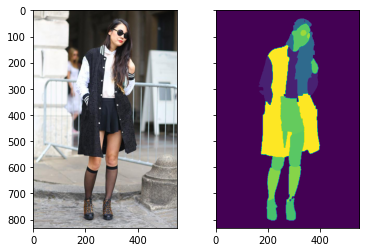

In [ ]:
# sample feature image and its corresponding annotations
q = Image.open(DATA_PATH + '/photos/0001.jpg')
fig, (ax1,ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
ax1.imshow(q)
ax2.imshow(t['groundtruth'])
plt.show()

### Preparation

In [ ]:
# saving category names as csv
labels = loadmat(DATA_PATH + '/label_list.mat')
ccp_categories = []
for i in labels['label_list'][0]:
    ccp_categories.append(str(i[0]))
pd.Series(ccp_categories).to_csv(DATA_PATH + '/color_map.csv')

In [ ]:
# # create a color palette using RGB values
# color_map = pd.read_csv(DATA_PATH + '/color_map.csv', header=None)
# color_map.columns = ['index','category','R','G','B']
# color_map['color'] = color_map[['R','G','B']].apply(lambda x: str(x['R']) + " " + str(x['G'])+ " " + str(x['B']), axis=1)
# palette = color_map[['R','G','B']].values
# palette = palette.reshape((59*3))
# palette = list(palette)

In [ ]:
# read all image annotations and create paletted images using them
!mkdir ./{DATA_PATH}/labels
annotations = glob(DATA_PATH + '/annotations/pixel-level/*.mat')
for f in annotations:
    gt = loadmat(f)['groundtruth']
    im = Image.fromarray(gt)
    im = im.convert('P')
    # im.putpalette(palette)
    im_new = im.convert(mode='RGB')
    im_path = DATA_PATH + '/labels/' + basename(f).split('.')[0] + '.png'
    im_new.save(im_path, format='PNG')

In [ ]:
# Re-sizing all feature images and labels, and saving them in th training folder
!mkdir -p ./data/train/photos ./data/train/labels
photos = glob(DATA_PATH + '/photos/*.jpg')
labels = glob(DATA_PATH + '/labels/*.png')
photos = photos[:1004]
for i in range(len(photos)):
    fea = Image.open(photos[i])
    fea = fea.resize(size=(500, 800))
    label = Image.open(labels[i])
    label = label.convert('RGB')
    label = label.resize(size=(500,800))
    fea_name = basename(photos[i])
    label_name = basename(labels[i])
    fea.save('./data/train/photos/' + fea_name)
    label.save('./data/train/labels/'+label_name, format='PNG')

In [ ]:
# Moving 200 images and labels from the trainig folder to the test folder
!mkdir -p ./data/test/photos ./data/test/labels
photos = glob('./data/train/photos/*.jpg')
labels = glob('./data/train/labels/*.png')
print(len(photos), len(labels))
move_to_test = random.sample(range(len(photos)), 200)
for i in move_to_test:
    shutil.copy(photos[i], './data/test/photos/')
    shutil.copy(labels[i], './data/test/labels/')
    os.remove(photos[i])
    os.remove(labels[i])

1004 1004


In [ ]:
# Saving labels in paletted form (P mode), would be required to measure accuracy and iou
!mkdir -p ./data/paletted
labels = glob(DATA_PATH + '/labels/*.png')
for i in range(len(labels)):
    label = Image.open(labels[i])
    label = label.resize(size=(500,800))
    label_name = basename(labels[i])
    label.save('./data/paletted/'+label_name, format='PNG')

Loading validations sets for evaluating accuarcy and iou. Also implementing CRF post processing for refinement, and to measure its impact on metrics.

In [ ]:
## caffe uses a series of transformations on data before feeding it into the neural networks
## creating a transformer for all such operations - channel swap, mean subtraction etc.
def getTransformer(net, mean_file_path = None):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255)
    if mean_file_path is not None:
        a = caffe.io.caffe_pb2.BlobProto()
        with open(mean_file_path,'rb') as f:
            a.ParseFromString(f.read())
        means = np.asarray(caffe.io.blobproto_to_array(a))[0]
        means = means.mean(1).mean(1)
        transformer.set_mean('data', means)
    return transformer

## this function runs the forward pass of the given 'net/model' for a given image
## outputs [softmax activations, predicted label image]
def getOutput(inputImagePath, net, transformer, palette):
    im_arr = caffe.io.load_image(inputImagePath)
    x, y, c = im_arr.shape
    net.blobs['data'].reshape(1, c, x, y)
    im_trans = transformer.preprocess('data', im_arr)
    net.blobs['data'].data[...] = im_trans
    layer_name = net.blobs.keys()[-1]
    out = net.forward()[layer_name][0]
    new = np.argmax(out, axis=0)
    new = new.astype('uint8')
    new_im = Image.fromarray(new, 'P')
    new_im.putpalette(palette)
    return out, new_im

## same as the above function
## but only outputs softmax probabilities
def getProba(inputImagePath, net, mean_file_path = None):
    im_arr = caffe.io.load_image(inputImagePath)
    x, y, c = im_arr.shape
    net.blobs['data'].reshape(1, c, x, y)
    transformer = getTransformer(net, mean_file_path)
    im_trans = transformer.preprocess('data', im_arr)
    net.blobs['data'].data[...] = im_trans
    layer_name = net.blobs.keys()[-1]
    out = net.forward()[layer_name][0]
    return out

In [ ]:
#given two matrices, prediction and label, this function outputs accuracy
def accuracy(prediction, truth):
    r = prediction == truth
    return 100.0*r.sum()/(r.shape[0]*r.shape[1]*1.0)

## this function outputs IOU, given two matrices
def get_IOU(prediction, truth):
    r = (prediction == truth) * (truth > 0)
    intersection = r.sum() * 2.0
    union = (truth != 0).sum() + (prediction != 0).sum()
    return 100*intersection/union

In [ ]:
## CRf
## takes feature image, softmax output of the model, color palette and number of classes as input
## color palette is used to generate the crf processed prediction
## number of classes is same as the number of categories in the classification task
## outputs final images as array and PIL Image form

def crf(image_arr, pred_prob, palette, num_classes):
    softmax = pred_prob.squeeze()
    unary = softmax_to_unary(softmax)
    unary = np.ascontiguousarray(unary)
    d = dcrf.DenseCRF(image_arr.shape[0] * image_arr.shape[1], num_classes)
    d.setUnaryEnergy(unary)
    feats = create_pairwise_gaussian(sdims=(2,2), shape=image_arr.shape[:2])
    bil = create_pairwise_bilateral(sdims=(50,50), schan=(12,12,12), img=image_arr, chdim=2)
    d.addPairwiseEnergy(bil, compat=5)
    d.addPairwiseEnergy(feats, compat=2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(10)
    res = np.argmax(Q, axis=0).reshape((image_arr.shape[0], image_arr.shape[1]))
    res = np.array(res, dtype=int)
    res_im = Image.fromarray(res)
    res_im = res_im.convert('P')
    res_im.putpalette(palette)
    
    return res, res_im

In [ ]:
## load trained model
FILE_PATH = '/content/drive/My Drive/'
net = caffe.Net(FILE_PATH + 'deploy.prototxt',
                FILE_PATH + 'snapshot_iter_1020.caffemodel',
                caffe.TEST)
mean_proto_path = FILE_PATH + 'mean.binaryproto'

## build transformer
transformer = getTransformer(net, mean_proto_path)

# ## read color map to build palette
# color_map = pd.read_csv('../preserves/color_map.csv', header = None)
# color_map.columns = ['i','category', 'R','G','B']
# palette = color_map[['R','G','B']].values
# palette = palette.reshape((59*3))
# palette = list(palette)

In [ ]:
## run forward pass on all validation set images and calculate accuracy and IOU
## Use CRF
## calculate accuracy and IOU over post-processed predictions
## add all the metrics to a table, and save to disk
## also save output images to disk, for future reference

validation_imgs = glob('../dataset_ccp/test/photos/*')
res = []
for img_path in validation_imgs:
    b_name = basename(img_path).split('.')[0]
    label_path = '../dataset_ccp/paletted/' + b_name + '.png'
    
    img_arr = np.asarray(Image.open(img_path))
    truth_arr = np.asarray(Image.open(label_path))
    
    pred_proba, pred = getOutput(img_path, net, transformer, palette)
    pred_arr = np.asarray(pred)

    crf_arr, crf_im = crf(img_arr, pred_proba, palette, 59)
    
    res.append([img_path,
                accuracy(pred_arr, truth_arr),
                get_IOU(pred_arr, truth_arr),
                accuracy(crf_arr, truth_arr),
                get_IOU(crf_arr, truth_arr)])
    
    print b_name
    
    pred.save('E:/Models/out_ccp/pred/' + b_name + '.png', format='PNG')
    crf_im.save('E:/Models/out_ccp/crf/' + b_name + '.png', format='PNG')
    
result = pd.DataFrame.from_records(res, columns=['img','acc','iou','acc_crf','iou_crf'])
result.to_csv('E:/Models/out_ccp/res_ccp_dataframe.csv', index=False)

In [ ]:
## reading the file
result_ccp = pd.read_csv('E:/Models/out_ccp/res_ccp_dataframe.csv')
result_ccp.head()

In [ ]:
print "IOU :", result_ccp.iou.mean(), "\tACC:", result_ccp.acc.mean()
print "IOU WITH CRF:", result_ccp.iou_crf.mean(), "\tACC WITH CRF:", result_ccp.acc_crf.mean()